## node2vec: Scalable Feature Learning for Networks

## 目录
### 读图，设置模型参数
### 计算点和边的alias table
### 有偏的随机游走生成节点序列
### 利用word2vec训练模型
### 结果展示和可视化

In [3]:
'''
Reference implementation of node2vec. 
Author: Aditya Grover
For more details, refer to the paper:
node2vec: Scalable Feature Learning for Networks
Aditya Grover and Jure Leskovec 
Knowledge Discovery and Data Mining (KDD), 2016
'''
import warnings
warnings.filterwarnings('ignore')
import argparse
import numpy as np
import networkx as nx
#import node2vec
from gensim.models import Word2Vec
import random
# 这里就是alias sampling本质上使用sorted(G.neighbors())就是为了保证创建graph和使用alias table里面的index是对齐的。并没有什么贪心算法。

### 1. 读图，设置模型参数

1) 设置模型参数
设置图相关参数，如有向无向图、权重图等，还有模型系数，如p、q、embedding长度等

2）读图
读图的方式很简单，我们使用networkx包直接加载edgelist

3）输入输出

输入文件'../graph/karate.edgelist'

输出文件'../emb/karate.emb'

In [4]:
def parse_args():
    '''
    Parses the node2vec arguments.
    '''
    # 使用parser加载信息
    parser = argparse.ArgumentParser(description="Run node2vec.")
    # 输入文件 
    parser.add_argument('--input', nargs='?', default='../graph/karate.edgelist',
                        help='Input graph path')
    # 输出文件
    parser.add_argument('--output', nargs='?', default='../emb/karate.emb',
                        help='Embeddings path')
    # embedding维度
    parser.add_argument('--dimensions', type=int, default=128,
                        help='Number of dimensions. Default is 128.')
    # 节点序列长度
    parser.add_argument('--walk-length', type=int, default=80,
                        help='Length of walk per source. Default is 80.')
    # 随机游走的次数
    parser.add_argument('--num-walks', type=int, default=10,
                        help='Number of walks per source. Default is 10.') # 这个就是每个点我们走几次
    # word2vec窗口大小，word2vec参数
    parser.add_argument('--window-size', type=int, default=10,
                        help='Context size for optimization. Default is 10.')
    # SGD优化时epoch数量，word2vec参数
    parser.add_argument('--iter', default=1, type=int,
                        help='Number of epochs in SGD')
    # 并行化核数，word2vec参数
    parser.add_argument('--workers', type=int, default=8,
                        help='Number of parallel workers. Default is 8.')
    # 参数p
    parser.add_argument('--p', type=float, default=1,
                        help='Return hyperparameter. Default is 1.')
    # 参数q
    parser.add_argument('--q', type=float, default=1,
                        help='Inout hyperparameter. Default is 1.')
    # 权重
    parser.add_argument('--weighted', dest='weighted', action='store_true',
                        help='Boolean specifying (un)weighted. Default is unweighted.')
    parser.add_argument('--unweighted', dest='unweighted', action='store_false')
    parser.set_defaults(weighted=False)
    # 有向无向
    parser.add_argument('--directed', dest='directed', action='store_true',
                        help='Graph is (un)directed. Default is undirected.')
    parser.add_argument('--undirected', dest='undirected', action='store_false')
    parser.set_defaults(directed=False)
    
    return parser.parse_args(args=[])
    # return parser.parse_known_args()

In [5]:
def read_graph():
    '''
    Reads the input network in networkx.
    '''
    # 权重图
    if args.weighted:
        G = nx.read_edgelist(args.input, nodetype=int, data=(('weight', float),), create_using=nx.DiGraph())
    # 无权图
    else:
        G = nx.read_edgelist(args.input, nodetype=int, create_using=nx.DiGraph())
        for edge in G.edges():
            G[edge[0]][edge[1]]['weight'] = 1
    # 无向操作
    if not args.directed:
        G = G.to_undirected()

    return G

In [6]:
# 设置模型参数
args = parse_args()
# 读图
nx_G = read_graph()
# 信息展示
print (len(nx_G))

34


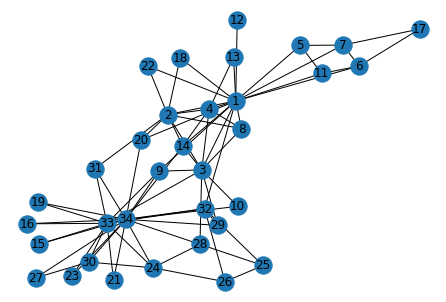

In [7]:
import matplotlib.pyplot as plt
nx.draw(nx_G, with_labels=True)
plt.show()

### 2. 计算点和边的alias table

In [8]:
class Graph(): # 对于walk的第一个点没办法进行alias sampling，所以我们必须获得node alias table和edge alias table，edge的就是保存了上一步的
    # 出事化设置参数
    def __init__(self, nx_G, is_directed, p, q):
        self.G = nx_G
        self.is_directed = is_directed
        self.p = p
        self.q = q
    
    
    def node2vec_walk(self, walk_length, start_node): # 就是生成一个游走序列+alias sampling。
        '''
        Simulate a random walk starting from start node.
        '''
        G = self.G
        # 上一步计算出的alias table，完成O(1)的采样
        alias_nodes = self.alias_nodes
        alias_edges = self.alias_edges

        walk = [start_node]

        #  直到生成长度为walk_length的节点序列位为止
        while len(walk) < walk_length:
            cur = walk[-1]
            # 对邻居节点排序，目的是和alias table计算时的顺序对应起来
            cur_nbrs = sorted(G.neighbors(cur))
            if len(cur_nbrs) > 0:
                # 节点序列只有一个节点的情况
                if len(walk) == 1:
                    walk.append(cur_nbrs[alias_draw(alias_nodes[cur][0], alias_nodes[cur][1])])
                # 节点序列大于一个节点的情况
                else:
                    # 看前一个节点,prev是论文中的节点t
                    prev = walk[-2]
                    next = cur_nbrs[alias_draw(alias_edges[(prev, cur)][0],
                        alias_edges[(prev, cur)][1])]
                    walk.append(next)
            else:
                break

        return walk

    def simulate_walks(self, num_walks, walk_length): # 生成num_walks个游走序列
        '''
        Repeatedly simulate random walks from each node.
        '''
        G = self.G
        walks = []
        nodes = list(G.nodes())
        print ('Walk iteration:')
        for walk_iter in range(num_walks):
            print (str(walk_iter+1), '/', str(num_walks))
            # 打乱节点顺序
            random.shuffle(nodes)
            for node in nodes:
                # node2vec_walk是一次有偏的随机游走
                walks.append(self.node2vec_walk(walk_length=walk_length, start_node=node))

        return walks 

    def get_alias_edge(self, src, dst):
        '''
        Get the alias edge setup lists for a given edge.
        '''
        G = self.G
        p = self.p
        q = self.q

        unnormalized_probs = []
        # 论文3.2.2节核心算法
        for dst_nbr in sorted(G.neighbors(dst)):
            if dst_nbr == src:
                unnormalized_probs.append(G[dst][dst_nbr]['weight']/p)
            elif G.has_edge(dst_nbr, src):
                unnormalized_probs.append(G[dst][dst_nbr]['weight'])
            else:
                unnormalized_probs.append(G[dst][dst_nbr]['weight']/q)
        
        # 归一化
        norm_const = sum(unnormalized_probs)
        normalized_probs =  [float(u_prob)/norm_const for u_prob in unnormalized_probs]

        return alias_setup(normalized_probs)

    def preprocess_transition_probs(self):
        '''
        Preprocessing of transition probabilities for guiding the random walks.
        '''
        G = self.G
        is_directed = self.is_directed

        alias_nodes = {}
        # 节点概率alias sampling和归一化
        for node in G.nodes(): 
            unnormalized_probs = [G[node][nbr]['weight'] for nbr in sorted(G.neighbors(node))]
            norm_const = sum(unnormalized_probs)
            normalized_probs =  [float(u_prob)/norm_const for u_prob in unnormalized_probs] # 转移概率生成。
            alias_nodes[node] = alias_setup(normalized_probs) # 
            # 信息展示
            if node == 2:
                print (unnormalized_probs) # 默认都是1
                print (norm_const) 
                print (normalized_probs)
                print (alias_nodes[node]) # 

        alias_edges = {}
        triads = {}
        
        # 边概率alias sampling和归一化
        if is_directed:
            for edge in G.edges():
                alias_edges[edge] = self.get_alias_edge(edge[0], edge[1])
        else:
            for edge in G.edges():
                alias_edges[edge] = self.get_alias_edge(edge[0], edge[1])
                alias_edges[(edge[1], edge[0])] = self.get_alias_edge(edge[1], edge[0])
        
        print ('edges alias')
        print (alias_edges[(2, 3)])
        
        self.alias_nodes = alias_nodes
        self.alias_edges = alias_edges

        return

<img src="../img/alg1.png"  width="400" height="400" align="left" />
<img src="../img/alg2.png"  width="400" height="400" align="left" />

In [9]:
def alias_setup(probs): # 队列算法，符合贪心的，sorted。针对任何一个概率列表就可以采样
    '''
    Compute utility lists for non-uniform sampling from discrete distributions.
    Refer to https://hips.seas.harvard.edu/blog/2013/03/03/the-alias-method-efficient-sampling-with-many-discrete-outcomes/
    for details
    '''
    K = len(probs)
    # q corrsespond to Prob
    q = np.zeros(K)
    # J Alias
    J = np.zeros(K, dtype=np.int)

    smaller = []
    larger = []
    
    # 将各个概率分成两组，一组的概率值大于1，另一组的概率值小于1
    for kk, prob in enumerate(probs):
        q[kk] = K*prob # 归一化
        if q[kk] < 1.0:
            smaller.append(kk)
        else:
            larger.append(kk)
    
    # 使用贪心算法，将概率值小于1的不断填满
    # pseudo code step 3
    while len(smaller) > 0 and len(larger) > 0:
        small = smaller.pop()
        large = larger.pop()

        J[small] = large
        # 更新概率值
        q[large] = q[large] + q[small] - 1.0
        if q[large] < 1.0:
            smaller.append(large)
        else:
            larger.append(large)

    return J, q # alias table保存的是原始的那个列的index，然后q这个prob保存的就是对应列的概率。

<img src="../img/alg3.png"  width="600" height="600" align="left" />

In [10]:
def alias_draw(J, q): # 这个就是采样的算法
    '''
    Draw sample from a non-uniform discrete distribution using alias sampling.
    '''
    K = len(J)

    kk = int(np.floor(np.random.rand()*K))
    # 取自己 
    if np.random.rand() < q[kk]:
        return kk
    # 取alias table存的节点
    else:
        return J[kk]

In [11]:
# 模型加载参数
# G = node2vec.Graph(nx_G, args.directed, args.p, args.q)
G = Graph(nx_G, args.directed, args.p, args.q)

# 信息展示1
print (G.G.nodes())

# 信息展示2
# G.is_directed
# G.p
# G.q

# 生成alias table
G.preprocess_transition_probs()
print ('nodes and edges alias sampling')

[1, 32, 22, 20, 18, 14, 13, 12, 11, 9, 8, 7, 6, 5, 4, 3, 2, 31, 10, 33, 29, 28, 17, 34, 15, 16, 19, 21, 23, 24, 30, 26, 25, 27]
[1, 1, 1, 1, 1, 1, 1, 1, 1]
9
[0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111]
(array([0, 0, 0, 0, 0, 0, 0, 0, 0]), array([1., 1., 1., 1., 1., 1., 1., 1., 1.]))
edges alias
(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))
nodes and edges alias sampling


### 3.有偏的随机游走生成节点序列

In [12]:
def simulate_walks(self, num_walks, walk_length):
    '''
    Repeatedly simulate random walks from each node.
    '''
    G = self.G
    walks = []
    nodes = list(G.nodes())
    print ('Walk iteration:')
    for walk_iter in range(num_walks): # 每走一个所有的nodes的walks，我们都shuffle一下。
        print (str(walk_iter+1), '/', str(num_walks))
        # 打乱节点顺序
        random.shuffle(nodes)
        for node in nodes:
            # node2vec_walk是一次有偏的随机游走
            walks.append(self.node2vec_walk(walk_length=walk_length, start_node=node))

    return walks

In [13]:
def node2vec_walk(self, walk_length, start_node):
    '''
    Simulate a random walk starting from start node.
    '''
    G = self.G
    # 上一步计算出的alias table，完成O(1)的采样
    alias_nodes = self.alias_nodes
    alias_edges = self.alias_edges

    walk = [start_node]
    
    #  直到生成长度为walk_length的节点序列位为止
    while len(walk) < walk_length:
        cur = walk[-1]
        # 对邻居节点排序，目的是和alias table计算时的顺序对应起来
        cur_nbrs = sorted(G.neighbors(cur))
        if len(cur_nbrs) > 0:
            # 节点序列只有一个节点的情况
            if len(walk) == 1:
                # alias_nodes[cur][0] -- alias table
                # alias_nodes[cur][1] -- probability table
                walk.append(cur_nbrs[alias_draw(alias_nodes[cur][0], alias_nodes[cur][1])])
            # 节点序列大于一个节点的情况
            else:
                # 看前一个节点,prev是论文中的节点t
                prev = walk[-2]
                next = cur_nbrs[alias_draw(alias_edges[(prev, cur)][0],
                    alias_edges[(prev, cur)][1])]
                walk.append(next)
        else:
            break

    return walk

In [14]:
# 有偏的随机游走生成节点序列
walks = G.simulate_walks(args.num_walks, args.walk_length)
# 展示一个节点序列的长度
print (len(walks[0]))

Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10
80


In [15]:
walks

[[32,
  29,
  32,
  33,
  30,
  34,
  20,
  34,
  30,
  34,
  20,
  1,
  14,
  4,
  3,
  29,
  32,
  25,
  28,
  3,
  33,
  23,
  33,
  3,
  28,
  34,
  19,
  34,
  15,
  33,
  31,
  34,
  20,
  1,
  6,
  11,
  5,
  7,
  6,
  11,
  5,
  11,
  5,
  7,
  1,
  3,
  29,
  32,
  26,
  25,
  28,
  24,
  28,
  25,
  28,
  24,
  34,
  20,
  2,
  22,
  1,
  2,
  22,
  1,
  32,
  33,
  15,
  33,
  31,
  2,
  1,
  6,
  11,
  1,
  13,
  4,
  14,
  1,
  22,
  1],
 [1,
  9,
  33,
  21,
  34,
  32,
  29,
  34,
  16,
  34,
  20,
  2,
  20,
  1,
  22,
  1,
  3,
  29,
  34,
  20,
  1,
  11,
  5,
  11,
  1,
  18,
  1,
  18,
  2,
  4,
  8,
  3,
  14,
  3,
  33,
  23,
  34,
  9,
  33,
  30,
  33,
  16,
  33,
  30,
  24,
  26,
  25,
  32,
  33,
  15,
  34,
  28,
  24,
  30,
  27,
  34,
  29,
  32,
  29,
  34,
  24,
  26,
  25,
  32,
  29,
  3,
  1,
  32,
  25,
  28,
  24,
  28,
  34,
  31,
  33,
  21,
  34,
  21,
  34,
  31],
 [22,
  1,
  20,
  2,
  31,
  2,
  20,
  2,
  3,
  10,
  34,
  31,
  33,
  3,
  10

### 4. 利用word2vec训练模型

In [16]:
def learn_embeddings(walks):
    '''
    Learn embeddings by optimizing the Skipgram objective using SGD.
    '''
    # 将node的类型int转化为string
    # walks = [map(str, walk) for walk in walks]
    walk_lol = []
    for walk in walks:
        tmp = []
        for node in walk:
            tmp.append(str(node))
        walk_lol.append(tmp) # int转化为str
    # 调用gensim包运行word2vec
    model = Word2Vec(walk_lol, size=args.dimensions, window=args.window_size, min_count=0, sg=1, workers=args.workers,
                     iter=args.iter)
    # model.save_word2vec_format(args.output)
    # 保存embedding信息
    model.wv.save_word2vec_format(args.output)

    return model

In [17]:
model = learn_embeddings(walks)
print ('finished')

finished


### 5. 结果展示和可视化

In [33]:
model['17']

array([-0.13241285,  0.06777508, -0.08532505, -0.02917826, -0.10529063,
       -0.03884133,  0.11788426, -0.14075007, -0.08582879, -0.03342414,
       -0.1134355 , -0.14061022,  0.18337138,  0.01930074,  0.21126851,
       -0.21716116, -0.13796113, -0.16481899,  0.07540645, -0.12640633,
       -0.00576676, -0.05068311,  0.07375061,  0.13882032, -0.18314886,
        0.20422648,  0.09465512, -0.23088916,  0.09359053, -0.15042475,
       -0.21134473,  0.00727914,  0.00473002,  0.28594464,  0.14527082,
        0.03955357,  0.08739702,  0.11187351,  0.06031063, -0.10538603,
        0.17051594, -0.08205724, -0.30060783, -0.0103219 , -0.04110247,
        0.13727278, -0.07728615, -0.06716624,  0.15556043, -0.0105393 ,
        0.16428739,  0.10765294, -0.20570533, -0.06310249,  0.12730733,
       -0.08316717, -0.01600154,  0.0151307 ,  0.07971772,  0.04798478,
        0.01486173,  0.0077951 ,  0.01095591, -0.00780802,  0.03244752,
        0.1268422 , -0.00778123, -0.0345684 ,  0.07611298, -0.07

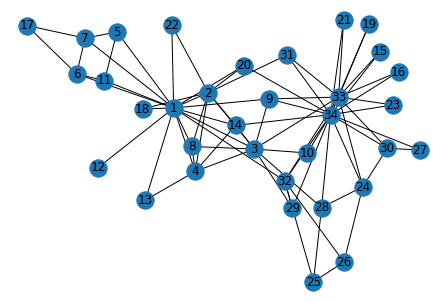

In [37]:
import matplotlib.pyplot as plt
nx.draw(nx_G, with_labels=True)
plt.show()

In [45]:
# # 相似节点组1
# print  (model.similarity('17', '6'))
# print  (model.similarity('7', '6'))
# print  (model.similarity('7', '5'))

# # 相似节点组2
# print  (model.similarity('34', '33'))
# print  (model.similarity('34', '9'))
# print  (model.similarity('34', '31'))

# # 不相似节点组
# print  (model.similarity('17', '25'))
# print  (model.similarity('7', '25'))

# # 找到和节点最相似的一组点
print (model.wv.most_similar('34'))

[('19', 0.9990527629852295), ('15', 0.9987644553184509), ('26', 0.9986506104469299), ('16', 0.9986443519592285), ('25', 0.9983014464378357), ('24', 0.9982528686523438), ('21', 0.9982346892356873), ('28', 0.9981457591056824), ('30', 0.9957606792449951), ('23', 0.9956749677658081)]


In [21]:
from scipy import spatial
def cos_similarity(v1, v2):
    return 1 - spatial.distance.cosine(v1, v2)

# # 相似节点组1
print (cos_similarity(model['17'], model['6']))
print (cos_similarity(model['7'], model['6']))
print (cos_similarity(model['7'], model['5']))


# # 相似节点组2
# print (cos_similarity(model['34'], model['33']))
# print (cos_similarity(model['34'], model['9']))
# print (cos_similarity(model['34'], model['31']))

# # 不相似节点组
# print (cos_similarity(model['17'], model['25']))
# print (cos_similarity(model['7'], model['25']))

0.9986644983291626
0.9942296743392944
0.9989559650421143


In [22]:
# k-means聚类
from sklearn import  cluster
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import train_test_split
import pandas as pd
embedding_node=[]
for i in range(1,35):
    j=str(i)
    embedding_node.append(model[j])
embedding_node=np.matrix(embedding_node).reshape((34,-1))
y_pred = cluster.KMeans(n_clusters=3, random_state=9).fit_predict(embedding_node) # 调用 test_RandomForestClassifier
y_pred


array([0, 2, 1, 2, 0, 0, 0, 0, 1, 1, 0, 2, 2, 1, 1, 1, 0, 2, 1, 2, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1], dtype=int32)

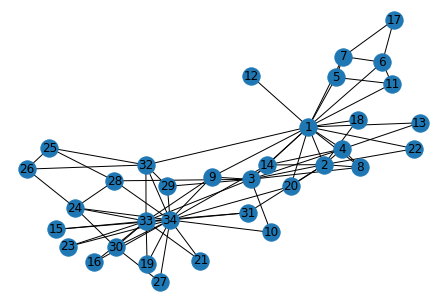

In [23]:
import matplotlib.pyplot as plt
nx.draw(nx_G, with_labels=True)
plt.show()